In [ ]:
# imports

from IPython.display import Image
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot  as plt
%matplotlib inline
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['font.size'] = 13
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# RUL prognosis approaches: Discussion

After reading some papers, I think the ways to go could be the following:

1. Although the challenge requests for RUL prediction, the problem could be tackled as a multiclass classification: Healthy engine, degradation phase, engine failure. This could be a reasonable approach for condition based maintenance since this would allow to schedule maintenance when the engine is already in the degradation phase. Also, tuning the class thresholds may be useful to adapt the algorithm to different clien requensts/expectations.

2. Using functional mappings between set of inputs and RUL (Using or not an intermediate health index). First transform the training data into a multidimensional feature space and use the RULs to label the feature vectors. Then all the machinery concerning supervised learning methods can be developed.

3. Similarity-based matching. Data from multiple units of the same system are used to create a library of degradation patterns. Then, for a new entity, distance mesures are computed to the degradation patterns available in the library. The RUL is finally defined, taking the RUL of the most similar model in the library at that point.

As an annex, here below we can find a summary of RUL prognosis algorithms/methods (T.Wang Phd thesis) that could be used following one of the three methods above.

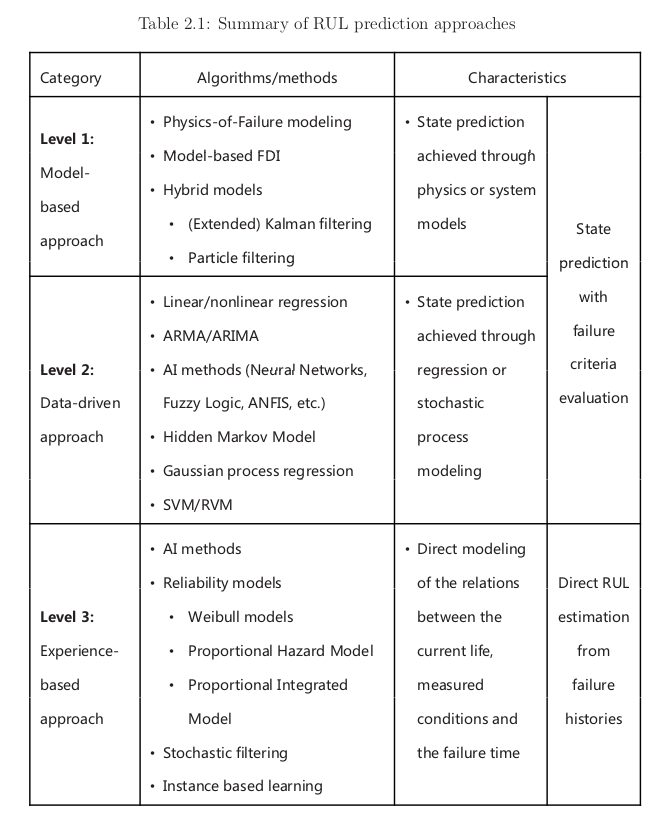

With more time I can go more in depth in each of the methods proposed and extract more concrete conclusions.

## First basic baseline

In order to get a flavour of the moin difficulties we may find, I developed a basic NN RUL prediction algorithm that fit in the second category explained above. Here below you can find the steps I took.

### RUL computation for test set

First step is to build the target variable for our data set, i.e. RUL. 

THe most obvious path to take is just specify the RUL as a linear count down until $t_fail$. However, some papers (Heimes, 08) suggest that a piece wise RUL function provides better results. THis piece-wise function would have a flat target output and, at some point, the engine will start to degradate, startint the count-down from that point onwards.

Here there is a picture illustrating what has been explained above

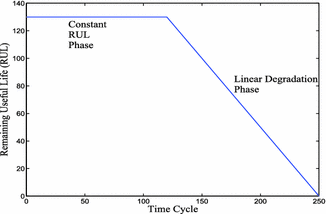

As for now, to keep things simple, we will proceed with the simple count down RUL.

In [ ]:
train_scaled = pd.read_csv('../1.Data/train_scaled.csv')
train_scaled.head()

In [ ]:
# Generate rul column

# get t_fail
rul = pd.DataFrame(train_scaled.groupby('unit_id')['t'].max()).reset_index()
rul.columns = ['unit_id', 'max']

# Insert a column with t_fail for every sample in the data set
train_scaled = train_scaled.merge(rul, on=['unit_id'], how='left')

# Substracting this column to cycle we get the count-down or RUL
train_scaled['rul'] = train_scaled['max'] - train_scaled['t']

# Remove unnecessary columns
train_scaled.drop('max', axis=1, inplace=True)
train_scaled.head()

### Train/test split

As explained in the previous notebook, since in the test set the trajectories don't end when the engine fails,  we are going to split the train data set itself in training and test.

In [ ]:
# Choose a random sample of 180 units among the original data set for training.
train_ids = np.random.choice(train_scaled.unit_id.unique(), size = 180, replace = False)

# Take the ones not chosen as test.
test_ids = list(set(train_scaled.unit_id.unique()) - set(np.unique(train_ids)))

# Filter original data set
train = train_scaled[train_scaled.unit_id.isin(list(train_ids))]
test = train_scaled[train_scaled.unit_id.isin(test_ids)]

### Model definition and training

This part is critical for the success of the challenge. There are a bunch of possible arquitectures out there and each one is specifically designed for the problem we want to solve. However, for time dependent problems or sequential problems, it has been showed that LSTM networks and all its variants work pretty well. 

Some examples of NN arquitectures can be found in these two papers:

- A review of deep learning in the study of materials degradation
- LSTM: A Search Space Odyssey

####  Data prep

One important thing to mention is that to keep the challenge simple in these first steps, we are going to feed the network with rolling window sequences of 50 cycles. With more work and coding, variable length sequences (as it is in our case, different t_fail for each engine) can be used to train the model.

First we need to prepare the data for the training of the network. THe LSTMs networks in Keras expect the data in the form of an array of 3 dimensions (samples, time steps, features) where samples is the number of training sequences , time steps is the sequence length and features is the number of features of each sequence at each time step.

In [ ]:
# Some useful column selection auxiliary variables

predictors = train.columns[train.columns.str.contains(pat = '[sen][set]', regex = True)]
sensors = train.columns[train.columns.str.contains(pat = 'sen', regex = True)]
settings = train.columns[train.columns.str.contains(pat = 'set', regex = True)]

In [ ]:
class SequenceGenerator():
    
    """
    Helper class to prepare data for network training
    """
    def __init__(self, df, seq_len, entity_id, features, target_name):
        self.df = df # Data frame we want to prepare
        self.seq_len = seq_len # Rolling window length (sequence length)
        self.entity_id = entity_id # Name of the entity identifier
        self.features = features # List of the predictor names
        self.target_name = target_name # Name of the target variable

        
    def stack_sequences_per_engine(self,e_id):
        
    """
    For the given entity id, e_id, generate the rolling window sequences of seq_len length.
    Stack all the sequences
    """
        
        X = self.df.loc[self.df[self.entity_id] == e_id, self.features].values
        y = self.df.loc[self.df[self.entity_id] == e_id,self.target_name].values
        
        X_stacked = np.empty((self.seq_len, len(self.features)))
        y_stacked = []
        
        len_i = len(y)
        
        for start, stop in zip(range(0, len_i-self.seq_len), range(self.seq_len, len_i)):
            
            X_stacked = np.dstack((X_stacked, X[start:stop,:]))
            y_stacked.append(y[stop])
            
        return X_stacked[:,:,1:], y_stacked
        
    def gen_data(self):
        
        """
        Generate stacked rolling window data for all entities in the data frame
        """
        
        X, y = [],[]
            
        for unit_id in self.df[self.entity_id].unique():
            X_i, y_i = self.stack_sequences_per_engine(unit_id)    
            X.append(X_i)
            y.append(y_i)
            
        return np.transpose(np.dstack(X), (2, 0, 1)),list(itertools.chain.from_iterable(y)) 


# Instantiate class and generate data  
seq_gen = SequenceGenerator(train, 50, 'unit_id', predictors, 'rul')
X,y = seq_gen.gen_data()

print(X.shape)
print(np.array(y).shape)

#### Network arquitecture

For now we will keep it simple and a network with two LSTM layers with 150 and 50 units, some dropout to avoid overfitting and finally a Dense layer with one unit that would output the desired RUL prognosis.

In [ ]:
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Dropout
    
# Define model arquitecture
model = Sequential()
model.add(LSTM(
         input_shape=(50, 24),
         units=150,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# COmpile model
model.compile(loss='mean_squared_error', optimizer='rmsprop')

# Print some info of the neural network
print(model.summary())

In [ ]:
# Train the model
history = model.fit(X, 
                    np.array(y), 
                    epochs=100, 
                    batch_size=200, 
                    validation_split=0.05, verbose=1)

In [ ]:
from keras.models import load_model
# Loading and Saving trained model
load=True
save = False

if load:
    model = load_model('29_Aug_LSTM_baseline.h5')
    
if save:
    model.save('29_Aug_LSTM_baseline.h5') 

In [ ]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()